# Calculate loss score of false triples 

## modules

In [2]:
import torch
import json
import pylab as plt
import pandas as pd
from IPython.display import display, HTML
from pykeen.datasets import get_dataset
from util.databinder import DataBinder

## parameters

In [8]:
#dir_false_triples = './data/processed/20240606_false_kinships_based_on_training_data'
#dir_model = './models/20240604/kinships_transe/'
dir_false_triples = './data/processed/20240621_false_wn18rr_based_on_training_data'
dir_model = './models/20240606/wn18rr_transe/'
#dir_false_triples = './data/processed/20240606_false_fb15k237_based_on_training_data'
#dir_model = './models/20240606/fb15k237_transe_no_option'

## main

### false triples

In [1]:
db_false_triples = DataBinder(target_dir=dir_false_triples)

list_random_seed = db_false_triples.get('list_random_seed')
dict_false_triples = {}
for random_seed in list_random_seed:
    i = int(random_seed)
    dict_false_triples[i] = {}
    dict_false_triples[i]['tf'] = db_false_triples.get(f'tf_{random_seed}')
    dict_false_triples[i]['df_feature'] = db_false_triples.get(f'df_tt_tf_features_{random_seed}')

NameError: name 'DataBinder' is not defined

### knowledge graph embeddign model

In [33]:
# embedding model
kge_model = torch.load(f'{dir_model}/trained_model.pkl')

In [34]:
## embeddign model information
with open(f'{dir_model}/results.json') as fin:
    dict_model_info = json.load(fin)

In [35]:
hits_at_1  = dict_model_info['metrics']['both']['realistic']['hits_at_1']
hits_at_3  = dict_model_info['metrics']['both']['realistic']['hits_at_3']
hits_at_5  = dict_model_info['metrics']['both']['realistic']['hits_at_5']
hits_at_10 = dict_model_info['metrics']['both']['realistic']['hits_at_10']

In [36]:
dict_data = {}
for i in [1,3,5,10]:
    dict_data[i] = dict_model_info['metrics']['both']['realistic'][f'hits_at_{i}']

In [37]:
sr_hits_at_k = pd.Series(dict_data, name='hits@k')
sr_hits_at_k.index.name = 'k'

In [38]:
sr_hits_at_k.to_frame().T

k,1,3,5,10
hits@k,0.008208,0.190321,0.273427,0.364398


### calculate score and true nagative ratio

In [42]:
for random_seed in dict_false_triples.keys():
    
    tf = dict_false_triples[random_seed]['tf']
    df_feature = dict_false_triples[random_seed]['df_feature']

    score_tf = kge_model.score_hrt(tf.mapped_triples).cpu().detach().numpy()
    df_feature['score'] = score_tf

    dict_false_triples[random_seed]['true_negative_ratio'] = {}
    n = len(df_feature)
    for k in [0.01, 0.03, 0.05]:
        n_top = int(n*k)
        df = df_feature.sort_values('score').head(n_top)
        threashold = df['score'].max()
        tn = len(df[df['is-error']==True])
        fp = len(df[df['is-error']==False])
        tnr = tn/(fp+tn)

        dict_false_triples[random_seed]['true_negative_ratio'][k] = {}
        dict_false_triples[random_seed]['true_negative_ratio'][k]['value'] = tnr
        dict_false_triples[random_seed]['true_negative_ratio'][k]['threashold'] = threashold

### display hits and true negative ratio

k,1,3,5,10
hits@k,0.008208,0.190321,0.273427,0.364398


Top,0.01,0.03,0.05
tnr(mean),1.0,0.980499,0.952914


Text(0, 0.5, 'true negative ratio')

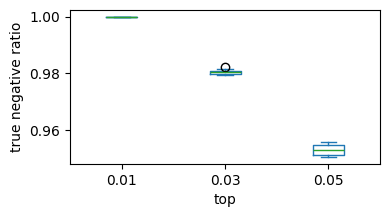

In [67]:
display(HTML('<h3>Hits@K</h3>'))
display(sr_hits_at_k.to_frame().T)

display(HTML('<h3>True negative ratio</h3>'))

dict_data_tnr = {}
for i in dict_false_triples.keys():
    dict_data_tnr[i] = {}
    for k in dict_false_triples[i]['true_negative_ratio'].keys():
        dict_data_tnr[i][k] = dict_false_triples[i]['true_negative_ratio'][k]['value']
df_tnr = pd.DataFrame(dict_data_tnr).T
df_tnr.columns.name = 'Top'

sr_tnr_mean = df_tnr.mean()
sr_tnr_mean.name = 'tnr(mean)'
display(sr_tnr_mean.to_frame().T)

fig, ax = plt.subplots(figsize=(4,2))
df_tnr.plot(kind='box', ax=ax)
ax.set_xlabel('top')
ax.set_ylabel('true negative ratio')

### 結果の分析

#### 従来の評価方法（True positive rate)

In [12]:
n = len(df_tt_tf_features)
dict_thd = {}
for k in [0.01, 0.03, 0.05]:
    n_top = int(n*k)
    df = df_tt_tf_features.sort_values('score_tf').head(n_top)
    dict_thd[k] = df['score_tf'].max()
    tn = len(df[df['is-error']==True])
    fp = len(df[df['is-error']==False])
    tnr = tn/(fp+tn)
    print(f'Top@{k}')
    print(f'\t n_top\t{n_top}')
    print(f'\t tn\t{tn}')
    print(f'\t fp\t{fp}')
    print(f'\t tn\t{tnr}')

Top@0.01
	 n_top	85
	 tn	26
	 fp	59
	 tn	0.3058823529411765
Top@0.03
	 n_top	256
	 tn	63
	 fp	193
	 tn	0.24609375
Top@0.05
	 n_top	427
	 tn	105
	 fp	322
	 tn	0.2459016393442623


#### スコア分布

Text(0, 0.5, 'ferq. (normed) \n false triples')

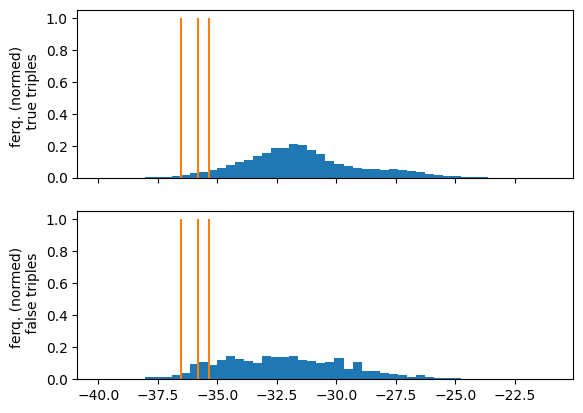

In [13]:
fig, axs = plt.subplots(nrows=2,sharex=True)

v_min = df_tt_tf_features['score_tf'].min()
v_max = df_tt_tf_features['score_tf'].max()

df_tt_tf_features[df_tt_tf_features['is-error']==False]['score_tf'].plot(kind='hist', bins=50, range=(v_min, v_max), ax=axs[0], density=True)
axs[0].vlines(dict_thd.values(), ymin=0, ymax=1, color='C1')
axs[0].set_ylabel('ferq. (normed) \n true triples')
#axs[0].set_ylim(0,0.3)

df_tt_tf_features[df_tt_tf_features['is-error']==True]['score_tf'].plot(kind='hist', bins=50, range=(v_min, v_max), ax=axs[1], density=True)
axs[1].vlines(dict_thd.values(), ymin=0, ymax=1, color='C1')
axs[1].set_ylabel('ferq. (normed) \n false triples')
#axs[1].set_ylim(0,0.3)

Text(0, 0.5, 'ferq. (normed) \n false triples')

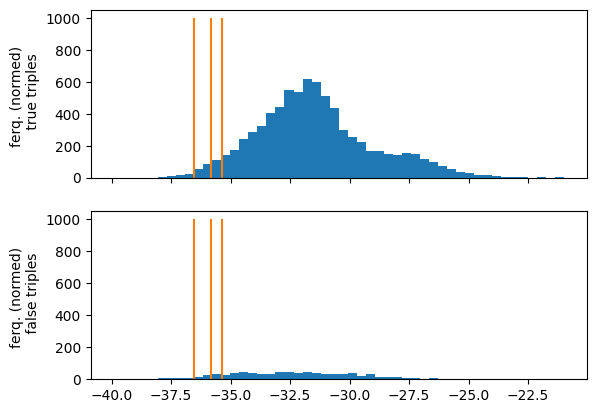

In [14]:
fig, axs = plt.subplots(nrows=2,sharex=True, sharey=True)

v_min = df_tt_tf_features['score_tf'].min()
v_max = df_tt_tf_features['score_tf'].max()

df_tt_tf_features[df_tt_tf_features['is-error']==False]['score_tf'].plot(kind='hist', bins=50, range=(v_min, v_max), ax=axs[0], density=False)
axs[0].vlines(dict_thd.values(), ymin=0, ymax=1000, color='C1')
axs[0].set_ylabel('ferq. (normed) \n true triples')
#axs[0].set_ylim(0,0.3)

df_tt_tf_features[df_tt_tf_features['is-error']==True]['score_tf'].plot(kind='hist', bins=50, range=(v_min, v_max), ax=axs[1], density=False)
axs[1].vlines(dict_thd.values(), ymin=0, ymax=1000, color='C1')
axs[1].set_ylabel('ferq. (normed) \n false triples')
#axs[1].set_ylim(0,0.3)

### 分析対象のトリプルを

In [15]:
n_top = int(len(df_tt_tf_features[df_tt_tf_features['is-error']==True])*0.05)
dict_df = {}
dict_df['all'] = df_tt_tf_features
dict_df['false_triples_with_low_score'] = df_tt_tf_features[df_tt_tf_features['is-error']==True].sort_values('score_tf').head(n_top)
dict_df['false_triples_with_high_score'] = df_tt_tf_features[df_tt_tf_features['is-error']==True].sort_values('score_tf', ascending=False).head(n_top)
dict_df['true_triples_with_low_score'] = df_tt_tf_features[df_tt_tf_features['is-error']==False].sort_values('score_tf').head(n_top)
dict_df['true_triples_with_high_score'] = df_tt_tf_features[df_tt_tf_features['is-error']==False].sort_values('score_tf', ascending=False).head(n_top)

In [16]:
n_top

40

### HeadとTailの特徴

#### 次数

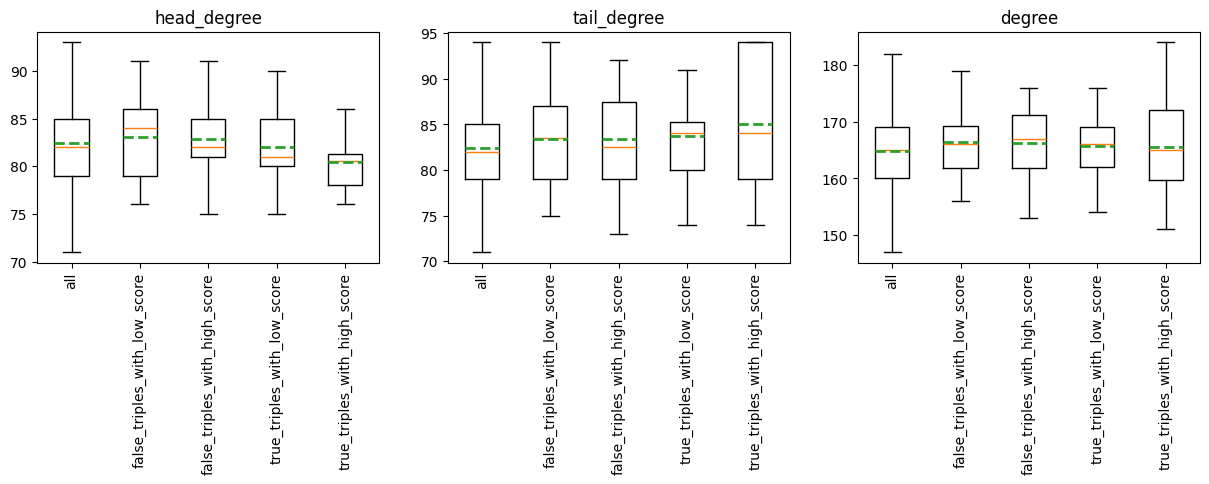

In [17]:
dict_values = {}
cols = ['head_degree', 'tail_degree', 'degree']
n_cols = len(cols)
fix, axs = plt.subplots(ncols=n_cols, figsize=(5*n_cols, 3))
dict_sr_mean = {}
for i, col in enumerate(cols):
    v = []
    v_mean = []
    for k, df in dict_df.items():
        v.append(df[col].values)
        v_mean.append(df[col].values.mean())
    axs[i].set_title(col)
    axs[i].boxplot(v, showmeans=True, meanline=True, meanprops={'lw':2}, showfliers=False)
    axs[i].set_xticklabels(list(dict_df.keys()), rotation=90)

    dict_sr_mean[col] = pd.Series(v_mean, index=list(dict_df.keys()))

### Relationの特徴

#### 頻度

In [18]:
list_sr_value_counts = []
for i, (k, df) in enumerate(dict_df.items()):
    sr_value_counts = df['relation'].value_counts()
    list_sr_value_counts.append(sr_value_counts/sr_value_counts.sum())
df_vaule_counts = pd.concat(list_sr_value_counts, axis=1).fillna(0)
df_vaule_counts.columns = list(dict_df.keys())

In [19]:
df_vaule_counts.sum()

all                              1.0
false_triples_with_low_score     1.0
false_triples_with_high_score    1.0
true_triples_with_low_score      1.0
true_triples_with_high_score     1.0
dtype: float64

<Axes: xlabel='relation'>

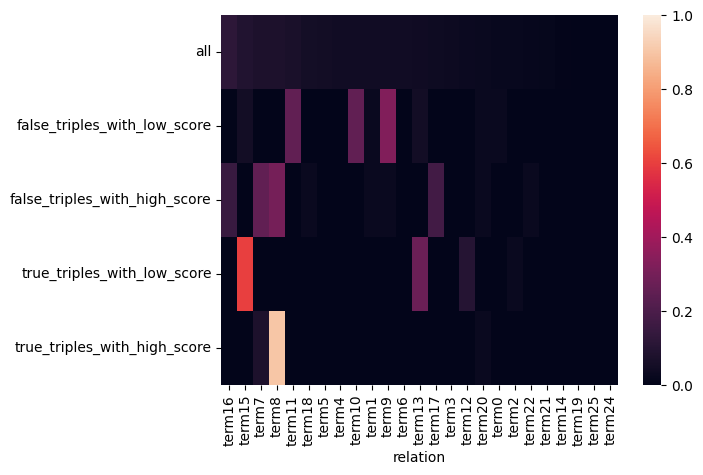

In [20]:
import seaborn as sns
sns.heatmap(df_vaule_counts.T, vmin=0, vmax=1.0)